# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

**Answer**:

I splitted data manually by picking 24 images out of each "A, B, C, ..., H, and I" folders for both validation and test data and storing them into Validation/ and Test/ folders. Whatever images remained, stored in Train/ folder for training purpose. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Lab3_Gestures_Summer/

/content/gdrive/MyDrive/Lab3_Gestures_Summer


In [ ]:
ls

Test/  Train/  Validation/


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

BATCH_SIZE = 32

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer/Train',
    transform=transform
)

validation_dataset = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer/Validation',
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer/Test',
    transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1
)

validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1
)

In [ ]:
print("The length of train data is:", len(train_dataset))
print("The length of validation data is:", len(validation_dataset))
print("The length of test data is:", len(test_dataset))

total = len(train_dataset) + len(validation_dataset) + len(test_dataset)
print("\nThe split summary:", "\ntrain", round(len(train_dataset)/total, 4)*100, "%", 
      "\nvalidation", round(len(validation_dataset)/total, 4)*100, "%", 
      "\ntest", round(len(test_dataset)/total, 4)*100, "%")

The length of train data is: 1787
The length of validation data is: 216
The length of test data is: 216

The split summary: 
train 80.53 % 
validation 9.73 % 
test 9.73 %


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

**Answer**:

I picked 2 convolution layers, 2 maxpooling layers, and 2 fully-connected layers: The first convolution layer is with 3 input channels, 5 output channels and kernel size of 5. The second convolution layer is with 5 input channels, 10 output channels and kernel size of 5. Both maxpooling layers are with kernel size of 2 and stride of 2. The first fully-connected layer is having input size of 10\*53\*53 and output size of 32. The second fully-connected layer is having input size of 32 and output size of 9. 

The input of cov1 is 3\*224\*224 and then after this layer it becomes 5\*220\*220 because o = (i+2p-k)/s + 1 = (224+0-5)/1 + 1 = 220. Then we apply relu on it and then a pooling layer with kernel size 2 and stride 2 which reduces the size to 5\*110\*110 because o = (i-k)/s + 1 = (220-2)/2 + 1 = 110. Then we apply another conv layer (conv2) which then the size becomes 10\*106\*106 because o = (i+2p-k)/s + 1 = (110+0-5)/1 + 1 = 106. Then we apply relu on it and then a pooling layer with kernel size 2 and stride 2 which reduces the size to 10\*53\*53 because o = (i-k)/s + 1 = (106-2)/2 + 1 = 53. Finally I applied a fully-connected layer with relu activation on top of it and then another final fully-connected layer to reduce the output size to 9 for my 9 classes (A, B, C, D, E, F, G, H, I).

In [ ]:
torch.manual_seed(1) # set the random seed

#Convolutional Neural Network Architecture
class CNN_Gesture(nn.Module):
    def __init__(self):
        super(CNN_Gesture, self).__init__()
        self.name = "cnn_gesture"
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

**Answer**:

I picked Cross Entropy for loss function because we are doing a multiclass classification and it's a preferred loss for classification. 

I chose SGD (Stochastic Gradient Descent) for optimizer because it can converge faster than batch training because it performs updates more frequently. 

In [ ]:
use_cuda = True

def get_accuracy(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
import matplotlib.pyplot as plt

def train(model, train_dataset, validation_dataset, learning_rate=0.001, batch_size=64, num_epochs=20):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CNN
CNN_Gesture(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.21544487968662562 |Validation acc: 0.19444444444444445
Epoch 3: Train acc: 0.3284834918858422 |Validation acc: 0.3194444444444444
Epoch 4: Train acc: 0.4051482932288752 |Validation acc: 0.4398148148148148
Epoch 5: Train acc: 0.5008393956351427 |Validation acc: 0.49074074074074076
Epoch 6: Train acc: 0.5271404588696139 |Validation acc: 0.49537037037037035
Epoch 7: Train acc: 0.5635142697257974 |Validation acc: 0.5694444444444444
Epoch 8: Train acc: 0.591494124230554 |Validation acc: 0.5555555555555556
Epoch 9: Train acc: 0.5948517067711248 |Validation 

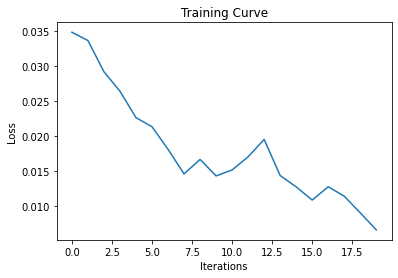

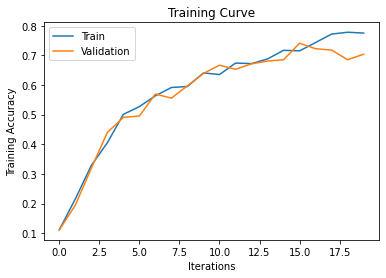

Final Training Accuracy: 0.7750419697817571
Final Validation Accuracy: 0.7037037037037037


In [ ]:
print("CNN")
model = CNN_Gesture()
print(model)
train(model, train_dataset, validation_dataset)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset_small = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer_Small/Train',
    transform=transform
)

validation_dataset_small = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer_Small/Validation',
    transform=transform
)

test_dataset_small = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer_Small/Test',
    transform=transform
)

print("The length of train data is:", len(train_dataset_small))
print("The length of validation data is:", len(validation_dataset_small))
print("The length of test data is:", len(test_dataset_small))

total = len(train_dataset_small) + len(validation_dataset_small) + len(test_dataset_small)
print("\nThe split summary:", "\ntrain", round(len(train_dataset_small)/total, 4)*100, "%", 
      "\nvalidation", round(len(validation_dataset_small)/total, 4)*100, "%", 
      "\ntest", round(len(test_dataset_small)/total, 4)*100, "%")

The length of train data is: 216
The length of validation data is: 27
The length of test data is: 27

The split summary: 
train 80.0 % 
validation 10.0 % 
test 10.0 %


In [ ]:
use_cuda = True

def get_accuracy_small(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train_small(model, train_dataset, validation_dataset, learning_rate=0.001, batch_size=24, num_epochs=200):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_small(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_small(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.10648148148148148 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.1111111111111111 |Validation acc: 0.1111111111111111
Epoch 3: Train acc: 0.1111111111111111 |Validation acc: 0.1111111111111111
Epoch 4: Train acc: 0.1111111111111111 |Validation acc: 0.1111111111111111
Epoch 5: Train acc: 0.14814814814814814 |Validation acc: 0.14814814814814814
Epoch 6: Train acc: 0.2175925925925926 |Validation acc: 0.18518518518518517
Epoch 7: Train acc: 0.24074074074074073 |Validation acc: 0.18518518518518517
Epoch 8: Train acc: 0.25 |Validation acc: 0.18518518518518517
Epoch 9: Train acc: 0.2962962962962963 |Validation acc: 0.18518518518518517
Epoch 10: Train acc: 0.33796296296296297 |Validation acc: 0.2962962962962963
Epoch 11: Train acc: 0.41203703703703703 |Validation acc: 0.37037037037037035
Epoch 12: Train acc: 0.4537037037037037 |Validation acc: 0.37037037037037035
Epoch 13: Train acc: 0.5046296296296297 |Validation acc: 0.5185185185185185
Epoch 14: Train acc: 0.

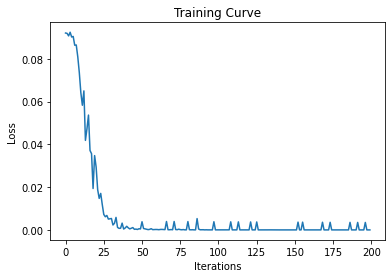

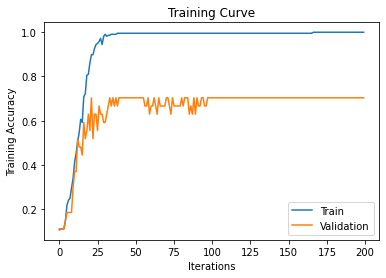

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7037037037037037


In [ ]:
small_model = CNN_Gesture()

train_small(small_model, train_dataset_small, validation_dataset_small)

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**Answer**:

batch size, learning rate, kernel size

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

**Changing batch size from 64 to 256:**

CNN: Increasing batch size from 64 to 256...
CNN_Gesture(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 3: Train acc: 0.2008953553441522 |Validation acc: 0.20833333333333334
Epoch 4: Train acc: 0.18522663682148852 |Validation acc: 0.18981481481481483
Epoch 5: Train acc: 0.19138220481253498 |Validation acc: 0.21296296296296297
Epoch 6: Train acc: 0.2686066032456631 |Validation acc: 0.27314814814814814
Epoch 7: Train acc: 0.2574146614437605 |Validation acc: 0.25
Epoch 8: Train acc: 0.2747621712367096 |Validation acc: 0.26851851851851855
Epoch 9: Train acc:

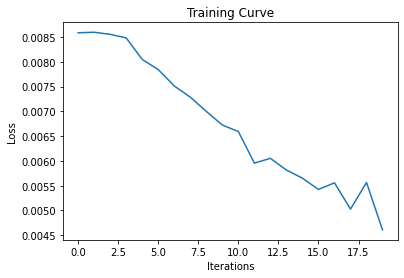

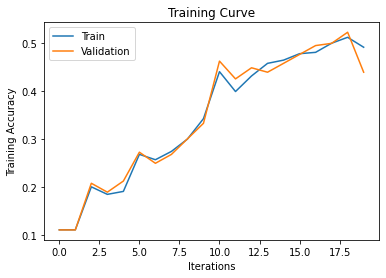

Final Training Accuracy: 0.4918858421936206
Final Validation Accuracy: 0.4398148148148148


In [ ]:
print("CNN: Increasing batch size from 64 to 256...")
model1 = CNN_Gesture()
print(model1)
train(model1, train_dataset, validation_dataset, batch_size=256)

**Changing kernel size from 5 to 3:**

CNN: Changing kernel size from 5 to 3 for Conv2d layers...
Convolutional Neural Network Architecture Done
CNN_Gesture_new(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=29160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.20145495243424735 |Validation acc: 0.19907407407407407
Epoch 3: Train acc: 0.19082260772243984 |Validation acc: 0.2037037037037037
Epoch 4: Train acc: 0.1986569669837717 |Validation acc: 0.19907407407407407
Epoch 5: Train acc: 0.19585898153329603 |Validation acc: 0.20833333333333334
Epoch 6: Train acc: 0.21208729714605484 |Validation acc: 0.20833333333333334
Epoch 7: Train acc: 0.22887520984890877 |Validation acc: 0.2222222222222222
Epoch 8: Train 

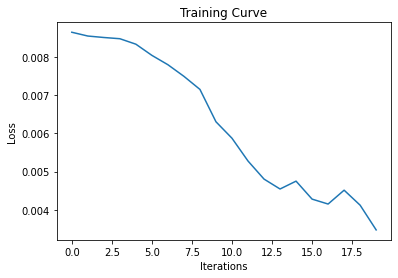

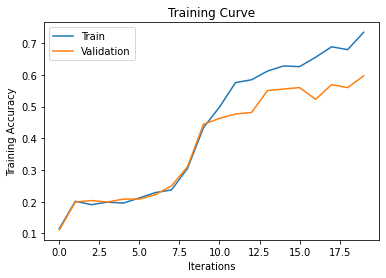

Final Training Accuracy: 0.7347509792949076
Final Validation Accuracy: 0.5972222222222222


In [ ]:
print("CNN: Changing kernel size from 5 to 3 for Conv2d layers...")

# The input of cov1 is 3*224*224 and then after this layer it becomes 5*222*222 because o = (i+2p-k)/s + 1 = (224+0-3)/1 + 1 = 222. 
# Then we apply relu on it and then a pooling layer with kernel size 2 and stride 2 which reduces the size to 5*111*111 because o = (i-k)/s + 1 = (222-2)/2 + 1 = 111. 
# Then we apply another conv layer (conv2) which then the size becomes 10*109*109 because o = (i+2p-k)/s + 1 = (111+0-3)/1 + 1 = 109. 
# Then we apply relu on it and then a pooling layer with kernel size 2 and stride 2 which reduces the size to 10*53*53 because o = (i-k)/s + 1 = (109-2)/2 + 1 = 54. 
# Finally I applied a fully-connected layer with relu activation on top of it and 
# then another final fully-connected layer to reduce the output size to 9 for my 9 classes (A, B, C, D, E, F, G, H, I).

torch.manual_seed(1) # set the random seed

#Convolutional Neural Network Architecture
class CNN_Gesture_new(nn.Module):
    def __init__(self):
        super(CNN_Gesture_new, self).__init__()
        self.name = "cnn_gesture_new"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 3) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 54 * 54, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

model2 = CNN_Gesture_new()
print(model2)
train(model2, train_dataset, validation_dataset, batch_size=256)

**Changing learning rate from 0.001 to 0.01:**

CNN: Increasing learning rate from 0.001 to 0.01...
CNN_Gesture(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 3: Train acc: 0.11303861219921657 |Validation acc: 0.1111111111111111
Epoch 4: Train acc: 0.11303861219921657 |Validation acc: 0.1111111111111111
Epoch 5: Train acc: 0.11303861219921657 |Validation acc: 0.1111111111111111
Epoch 6: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 7: Train acc: 0.11247901510912144 |Validation acc: 0.1111111111111111
Epoch 8: Train acc: 0.11303861219921657 |Validation acc: 0.1111111111111111


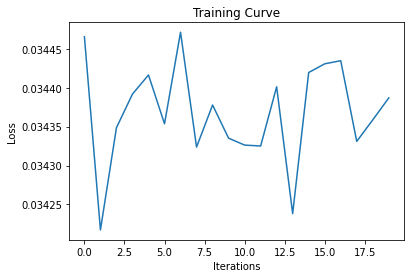

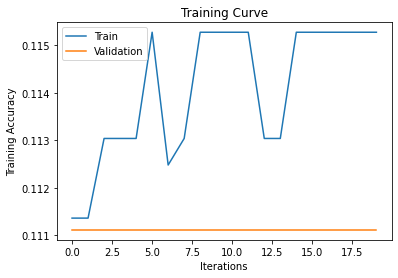

Final Training Accuracy: 0.1152770005595971
Final Validation Accuracy: 0.1111111111111111


In [ ]:
print("CNN: Increasing learning rate from 0.001 to 0.01...")
model3 = CNN_Gesture()
print(model3)
train(model3, train_dataset, validation_dataset, learning_rate=0.01)

**Changing batch size from 64 to 32:**

CNN: Reducing batch size from 64 to 32...
CNN_Gesture(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 3: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 4: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 5: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 6: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 7: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 8: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 9: 

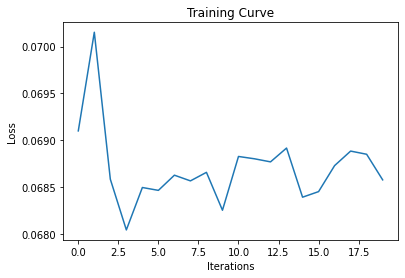

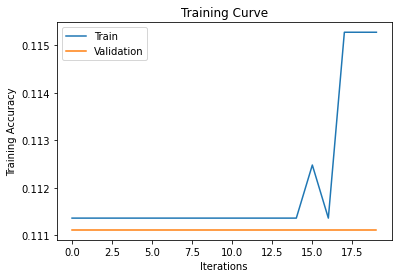

Final Training Accuracy: 0.1152770005595971
Final Validation Accuracy: 0.1111111111111111


In [ ]:
print("CNN: Reducing batch size from 64 to 32...")
model4 = CNN_Gesture()
print(model4)
train(model4, train_dataset, validation_dataset, batch_size=32)

**Changing learning rate from 0.001 to 0.005:**

CNN: Increasing learning rate from 0.001 to 0.005...
CNN_Gesture(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 3: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 4: Train acc: 0.11135982092893117 |Validation acc: 0.1111111111111111
Epoch 5: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 6: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 7: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 8: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Ep

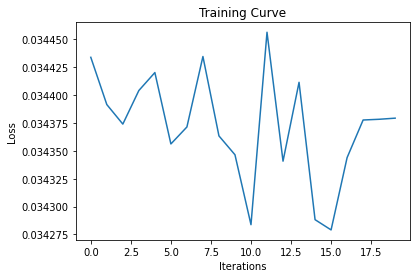

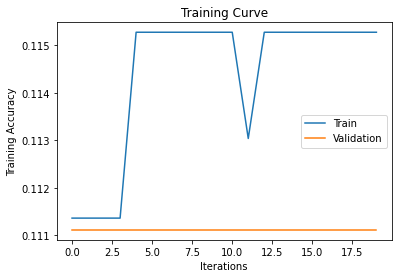

Final Training Accuracy: 0.1152770005595971
Final Validation Accuracy: 0.1111111111111111


In [ ]:
print("CNN: Increasing learning rate from 0.001 to 0.005...")
model5 = CNN_Gesture()
print(model5)
train(model5, train_dataset, validation_dataset, learning_rate=0.005)

**Default (initial) model with learning_rate=0.001, batch_size=64, kernel_size=5:**

CNN_Gesture(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.49468382764409624 |Validation acc: 0.4861111111111111
Epoch 2: Train acc: 0.6189143816452154 |Validation acc: 0.5879629629629629
Epoch 3: Train acc: 0.7213206491326245 |Validation acc: 0.6481481481481481
Epoch 4: Train acc: 0.735870173475098 |Validation acc: 0.6574074074074074
Epoch 5: Train acc: 0.7470621152770005 |Validation acc: 0.6620370370370371
Epoch 6: Train acc: 0.7688864017907107 |Validation acc: 0.6944444444444444
Epoch 7: Train acc: 0.8142137660884163 |Validation acc: 0.7037037037037037
Epoch 8: Train acc: 0.8371572467823167 |Validation acc: 0.6898148148148148
Epoch 9: Train acc: 0.8612199216564074 |Validation acc: 0.7

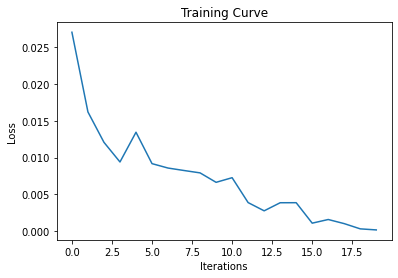

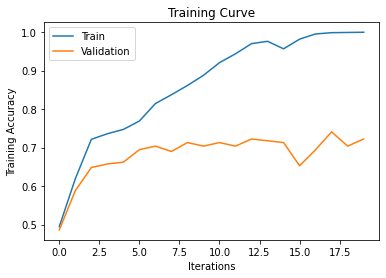

Final Training Accuracy: 0.9994404029099049
Final Validation Accuracy: 0.7222222222222222


In [ ]:
model6 = CNN_Gesture()
print(model6)
train(model6, train_dataset, validation_dataset)

**A better way to search for the best hyperparameters is Random Search. Trying out below combination with keeping kernel_size constant (kernel_size=5):**

**batch_size_list = [32, 32, 64, 64, 128, 128]**

**learning_rate_list = [0.01, 0.001, 0.001, 0.0001, 0.005, 0.001]**

In [ ]:
torch.manual_seed(1) # set the random seed

#Convolutional Neural Network Architecture
class CNN_Gesture_searching(nn.Module):
    def __init__(self):
        super(CNN_Gesture_searching, self).__init__()
        self.name = "cnn_gesture_searching"
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
use_cuda = True

def get_accuracy(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train_searching(model, train_dataset, validation_dataset, learning_rate, batch_size, num_epochs):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
#batch size, learning rate, kernel size
batch_size_list = [32, 32, 64, 64, 128, 128]
learning_rate_list = [0.01, 0.001, 0.001, 0.0001, 0.005, 0.001]
# kernel_size = [3, 5, 3, 5, 3, 5]
for i in range(len(batch_size_list)):
  print("\nCNN")
  model_searching = CNN_Gesture_searching()
  print(model_searching)
  train_searching(model_searching, train_dataset, validation_dataset, learning_rate_list[i], batch_size_list[i], 15) 


CNN
CNN_Gesture_searching(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.10968102965864578 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 3: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 4: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 5: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 6: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 7: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 8: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 9: Train acc: 0.1152770005595971 |Val

**Again doing Random Search with below combination with keeping kernel_size constant but this time set it to 3 instead of 5 (kernel_size=3):**

**batch_size_list = [32, 64, 64, 128]**

**learning_rate_list = [0.001, 0.001, 0.0001, 0.001]**

In [ ]:
torch.manual_seed(1) # set the random seed

#Convolutional Neural Network Architecture
class CNN_Gesture_new(nn.Module):
    def __init__(self):
        super(CNN_Gesture_new, self).__init__()
        self.name = "cnn_gesture_new"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 3) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 54 * 54, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
use_cuda = True

def get_accuracy(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train_searching(model, train_dataset, validation_dataset, learning_rate, batch_size, num_epochs):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
#batch size, learning rate, kernel size
batch_size_list = [32, 64, 64, 128]
learning_rate_list = [0.001, 0.001, 0.0001, 0.001]
# kernel_size = [3, 5, 3, 5, 3, 5]
for i in range(len(batch_size_list)):
  print("\nCNN")
  model_searching = CNN_Gesture_new()
  print(model_searching)
  train_searching(model_searching, train_dataset, validation_dataset, learning_rate_list[i], batch_size_list[i], 15) 


CNN
CNN_Gesture_new(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=29160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 1: Train acc: 0.1152770005595971 |Validation acc: 0.1111111111111111
Epoch 2: Train acc: 0.32624510352546165 |Validation acc: 0.30092592592592593
Epoch 3: Train acc: 0.6620033575825406 |Validation acc: 0.5833333333333334
Epoch 4: Train acc: 0.7291550083939563 |Validation acc: 0.6342592592592593
Epoch 5: Train acc: 0.7722439843312815 |Validation acc: 0.6805555555555556
Epoch 6: Train acc: 0.8136541689983212 |Validation acc: 0.6805555555555556
Epoch 7: Train acc: 0.8528259653049804 |Validation acc: 0.7037037037037037
Epoch 8: Train acc: 0.8847229994404029 |Validation acc: 0.6898148148148148
Epoch 9: Train acc: 0.8774482372691662 |Validati

**Again doing Random Search with below combination with keeping kernel_size constant but this time set it to 7 instead of 5 (kernel_size=7):**

**batch_size_list = [32, 64, 64, 128]**

**learning_rate_list = [0.001, 0.001, 0.0001, 0.001]**

In [ ]:
print("CNN: Changing kernel size from 5 to 7 for Conv2d layers...")

# The input of cov1 is 3*224*224 and then after this layer it becomes 5*218*218 because o = (i+2p-k)/s + 1 = (224+0-7)/1 + 1 = 218. 
# Then we apply relu on it and then a pooling layer with kernel size 2 and stride 2 which reduces the size to 5*109*109 because o = (i-k)/s + 1 = (218-2)/2 + 1 = 109. 
# Then we apply another conv layer (conv2) which then the size becomes 10*109*109 because o = (i+2p-k)/s + 1 = (109+0-7)/1 + 1 = 103. 
# Then we apply relu on it and then a pooling layer with kernel size 2 and stride 2 which reduces the size to 10*51*51 because o = (i-k)/s + 1 = (103-2)/2 + 1 = 51. 
# Finally I applied a fully-connected layer with relu activation on top of it and 
# then another final fully-connected layer to reduce the output size to 9 for my 9 classes (A, B, C, D, E, F, G, H, I).

torch.manual_seed(1) # set the random seed

#Convolutional Neural Network Architecture
class CNN_Gesture_7(nn.Module):
    def __init__(self):
        super(CNN_Gesture_7, self).__init__()
        self.name = "cnn_gesture_7"
        self.conv1 = nn.Conv2d(3, 5, 7) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 7) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 51 * 51, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 51 * 51)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

CNN: Changing kernel size from 5 to 7 for Conv2d layers...
Convolutional Neural Network Architecture Done


In [ ]:
use_cuda = True

def get_accuracy_7(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
import matplotlib.pyplot as plt

def train_7(model, train_dataset, validation_dataset, learning_rate, batch_size, num_epochs):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_7(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_7(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [ ]:
#batch size, learning rate, kernel size
batch_size_list_7 = [32, 64, 64, 128]
learning_rate_list_7 = [0.001, 0.001, 0.0001, 0.001]
# kernel_size = [3, 5, 3, 5, 3, 5]
for i in range(len(batch_size_list_7)):
  model_7 = CNN_Gesture_7()
  train_7(model_7, train_dataset, validation_dataset, learning_rate_list_7[i], batch_size_list_7[i], 15) 

Epoch 1: Train acc: 0.5293788472299944 |Validation acc: 0.46296296296296297
Epoch 2: Train acc: 0.6625629546726357 |Validation acc: 0.6296296296296297
Epoch 3: Train acc: 0.6648013430330162 |Validation acc: 0.6527777777777778
Epoch 4: Train acc: 0.7353105763850027 |Validation acc: 0.6805555555555556
Epoch 5: Train acc: 0.7392277560156687 |Validation acc: 0.6898148148148148
Epoch 6: Train acc: 0.8035814213766088 |Validation acc: 0.7129629629629629
Epoch 7: Train acc: 0.8080581980973699 |Validation acc: 0.7037037037037037
Epoch 8: Train acc: 0.8360380526021265 |Validation acc: 0.7222222222222222
Epoch 9: Train acc: 0.8483491885842194 |Validation acc: 0.7268518518518519
Epoch 10: Train acc: 0.8942361499720202 |Validation acc: 0.7314814814814815
Epoch 11: Train acc: 0.9054280917739228 |Validation acc: 0.7268518518518519
Epoch 12: Train acc: 0.9238947957470621 |Validation acc: 0.7546296296296297
Epoch 13: Train acc: 0.9334079462786794 |Validation acc: 0.75
Epoch 14: Train acc: 0.95075545607

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**Answer**:

My best model is this: batch size=32, learning rate=0.001, kernel size=7. 

Because validation accuracy is around 73% which is the highest and training accuracy is around 95 to 97% and since there's not a huge gap between my validation and training accuracy, the model is not really overfitting. Although I found other models with higher training accuracy (around 99%), but validation accuracy was not above 73%. So my final model is having batch size of 32, learning rate of 0.001, and kernel size of 7.

In [ ]:
import matplotlib.pyplot as plt

def train_7_plot(model, train_dataset, validation_dataset, learning_rate, batch_size, num_epochs):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_7(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_7(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.429770565193061 |Validation acc: 0.3888888888888889
Epoch 2: Train acc: 0.6261891438164522 |Validation acc: 0.5601851851851852
Epoch 3: Train acc: 0.6821488528259653 |Validation acc: 0.6527777777777778
Epoch 4: Train acc: 0.7151650811415781 |Validation acc: 0.6481481481481481
Epoch 5: Train acc: 0.7565752658086178 |Validation acc: 0.6712962962962963
Epoch 6: Train acc: 0.7895914941242306 |Validation acc: 0.6712962962962963
Epoch 7: Train acc: 0.7963066592053721 |Validation acc: 0.6851851851851852
Epoch 8: Train acc: 0.8198097369893677 |Validation acc: 0.7222222222222222
Epoch 9: Train acc: 0.855623950755456 |Validation acc: 0.7083333333333334
Epoch 10: Train acc: 0.8740906547285954 |Validation acc: 0.7175925925925926
Epoch 11: Train acc: 0.9143816452154448 |Validation acc: 0.7453703703703703
Epoch 12: Train acc: 0.9138220481253497 |Validation acc: 0.7037037037037037
Epoch 13: Train acc: 0.9272523782876329 |Validation acc: 0.7268518518518519
Epoch 14: Train acc: 0.

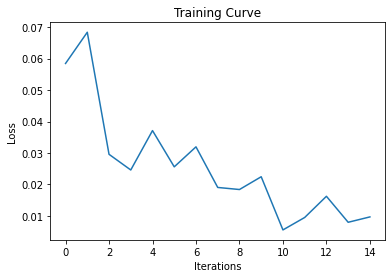

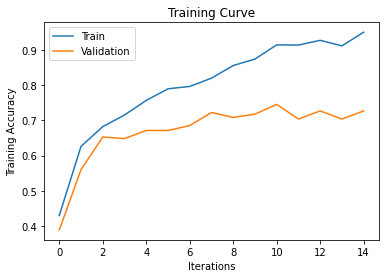

Final Training Accuracy: 0.9501958589815332
Final Validation Accuracy: 0.7268518518518519


In [ ]:
model_7_toPlot = CNN_Gesture_7()
train_7_plot(model_7_toPlot, train_dataset, validation_dataset, 0.001, 32, 15)

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

**Answer**:

We can see that we get a good test accuracy which is around 64% and is close to our validation accuracy which was around 73%. 

In [ ]:
use_cuda = True

def get_accuracy_for_test(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

test_loader = DataLoader(
    test_dataset, batch_size=32, 
    shuffle=True
)
test_acc = get_accuracy_for_test(model_7_toPlot, test_loader)
print(("Test acc: {}").format(test_acc))

Test acc: 0.6435185185185185


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
# features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer/Train',
    transform=transform
)

validation_dataset = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer/Validation',
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer/Test',
    transform=transform
)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
Train_features, Validation_features, Test_features = [], [], []
Train_labels, Validation_labels, Test_labels = [], [], []

# name should be Train, Validation or Test
def AlexNet_features(dataset, name, batch_size=1, num_workers=1):
  data_loader = DataLoader(
    dataset, batch_size=batch_size, 
    shuffle=True, num_workers=num_workers
  )
  n = 0
  for imgs, labels in iter(data_loader):
    features = alexnet.features(imgs)
    if name == 'Train':
      Train_features.append(alexnet.features(imgs))
      Train_labels.append(labels)
    elif name == 'Validation':
      Validation_features.append(alexnet.features(imgs))
      Validation_labels.append(labels)
    elif name == 'Test':
      Test_features.append(alexnet.features(imgs))
      Test_labels.append(labels)
    else:
      print("You picked an incorrect 'name'. Please replace 'name' with Train, Validation or Test.")
      return None
    features_tensor = torch.from_numpy(features.detach().numpy())
    torch.save(features_tensor.squeeze(0), '/content/gdrive/MyDrive/Lab3_Gestures_Summer_AlexNet/' + name + '/' + classes[labels] + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
AlexNet_features(train_dataset, 'Train')

In [ ]:
AlexNet_features(validation_dataset, 'Validation')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

**Answer**:

I picked 2 convolution layers, and 2 fully-connected layers: The first convolution layer is with 256 input channels, 60 output channels and kernel size of 3. The second convolution layer is with 60 input channels, 10 output channels and kernel size of 2. The first fully-connected layer is having input size of 10\*3\*3 and output size of 32. The second fully-connected layer is having input size of 32 and output size of 9. 

The input of cov1 is 256\*6\*6 and then after this layer which has kernel size of 3, it becomes 60\*4\*4 because o = (i+2p-k)/s + 1 = (6+0-3)/1 + 1 = 4. Then we apply another conv layer (conv2) with kernel size of 2 which then the size becomes 10\3\*3 because o = (i+2p-k)/s + 1 = (4+0-2)/1 + 1 = 3. Finally I applied a fully-connected layer with relu activation on top of it and then another final fully-connected layer to reduce the output size to 9 for my 9 classes (A, B, C, D, E, F, G, H, I).

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
# output = model(features)
# prob = F.softmax(output)

torch.manual_seed(1) # set the random seed

#Convolutional Neural Network Architecture
class CNN_AlexNet(nn.Module):
    def __init__(self):
        super(CNN_AlexNet, self).__init__()
        self.name = "cnn_alexnet"
        self.conv1 = nn.Conv2d(256, 60, 3) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(60, 10, 2) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
train_dataset_cnn_alexnet = datasets.DatasetFolder(
    '/content/gdrive/MyDrive/Lab3_Gestures_Summer_AlexNet/Train', 
    loader=torch.load, 
    extensions=('.tensor')
    )

validation_dataset_cnn_alexnet = datasets.DatasetFolder(
    '/content/gdrive/MyDrive/Lab3_Gestures_Summer_AlexNet/Validation', 
    loader=torch.load, 
    extensions=('.tensor')
    )

test_dataset_cnn_alexnet = datasets.DatasetFolder(
    '/content/gdrive/MyDrive/Lab3_Gestures_Summer_AlexNet/Test', 
    loader=torch.load, 
    extensions=('.tensor')
    )

train_loader_cnn_alexnet = DataLoader(
    train_dataset_cnn_alexnet, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1
)

validation_loader_cnn_alexnet = DataLoader(
    validation_dataset_cnn_alexnet, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1
)

test_loader_cnn_alexnet = DataLoader(
    test_dataset_cnn_alexnet, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1
)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

**Doing Random Search with below combinations:**

**batch_size_list_cnn_alexnet = [32, 64, 64, 128]**

**learning_rate_list_cnn_alexnet = [0.001, 0.001, 0.0001, 0.001]**

In [ ]:
# tensor = torch.from_numpy(tensor.detach().numpy())

In [ ]:
use_cuda = True

def get_accuracy_cnn_alexnet(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
import matplotlib.pyplot as plt

def train_cnn_alexnet(model, train_dataset, validation_dataset, learning_rate, batch_size, num_epochs):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_cnn_alexnet(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_cnn_alexnet(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    """ plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))"""

In [ ]:
#batch size, learning rate
batch_size_list_cnn_alexnet = [32, 64, 64, 128, 256]
learning_rate_list_cnn_alexnet = [0.001, 0.001, 0.0001, 0.001, 0.001]
# kernel_size = [3, 5, 3, 5, 3, 5]
for i in range(len(batch_size_list_cnn_alexnet)):
  print("\n")
  model_cnn_alexnet = CNN_AlexNet()
  train_cnn_alexnet(model_cnn_alexnet, train_dataset_cnn_alexnet, validation_dataset_cnn_alexnet, learning_rate_list_cnn_alexnet[i], batch_size_list_cnn_alexnet[i], 15) 



Epoch 1: Train acc: 0.8449789996181749 |Validation acc: 0.7965217391304348
Epoch 2: Train acc: 0.9587628865979382 |Validation acc: 0.8504347826086956
Epoch 3: Train acc: 0.9845360824742269 |Validation acc: 0.8556521739130435
Epoch 4: Train acc: 0.9965635738831615 |Validation acc: 0.8869565217391304
Epoch 5: Train acc: 0.9990454371897671 |Validation acc: 0.8747826086956522
Epoch 6: Train acc: 0.9992363497518136 |Validation acc: 0.8765217391304347
Epoch 7: Train acc: 0.9996181748759069 |Validation acc: 0.8747826086956522
Epoch 8: Train acc: 0.9996181748759069 |Validation acc: 0.8730434782608696
Epoch 9: Train acc: 0.9996181748759069 |Validation acc: 0.88
Epoch 10: Train acc: 0.9280259641084383 |Validation acc: 0.84
Epoch 11: Train acc: 0.9914089347079038 |Validation acc: 0.8904347826086957
Epoch 12: Train acc: 0.9996181748759069 |Validation acc: 0.8921739130434783
Epoch 13: Train acc: 0.9996181748759069 |Validation acc: 0.8817391304347826
Epoch 14: Train acc: 0.9996181748759069 |Valida

**Answer**:

My best model is this: batch size=64, learning rate=0.001. 

Because validation accuracy is around 94% which is the highest and training accuracy is around 99% and since there's not a huge gap between my validation and training accuracy, the model is not really overfitting and so it's the best model.

In [ ]:
import matplotlib.pyplot as plt

def train_cnn_alexnet_plot(model, train_dataset, validation_dataset, learning_rate, batch_size, num_epochs):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True
    )

    validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, 
    shuffle=True
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    #n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        #n += 1
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy_cnn_alexnet(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_cnn_alexnet(model, validation_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.9026345933562429 |Validation acc: 0.7843478260869565
Epoch 2: Train acc: 0.9753722794959908 |Validation acc: 0.8817391304347826
Epoch 3: Train acc: 0.9889270714012982 |Validation acc: 0.9043478260869565
Epoch 4: Train acc: 0.995418098510882 |Validation acc: 0.9043478260869565
Epoch 5: Train acc: 0.9984726995036274 |Validation acc: 0.9043478260869565
Epoch 6: Train acc: 0.9996181748759069 |Validation acc: 0.9252173913043479
Epoch 7: Train acc: 0.9996181748759069 |Validation acc: 0.9252173913043479
Epoch 8: Train acc: 0.9996181748759069 |Validation acc: 0.9113043478260869
Epoch 9: Train acc: 0.9996181748759069 |Validation acc: 0.928695652173913
Epoch 10: Train acc: 0.9904543718976708 |Validation acc: 0.8869565217391304
Epoch 11: Train acc: 0.9963726613211149 |Validation acc: 0.9217391304347826
Epoch 12: Train acc: 0.9996181748759069 |Validation acc: 0.9269565217391305
Epoch 13: Train acc: 0.9996181748759069 |Validation acc: 0.9408695652173913
Epoch 14: Train acc: 0.

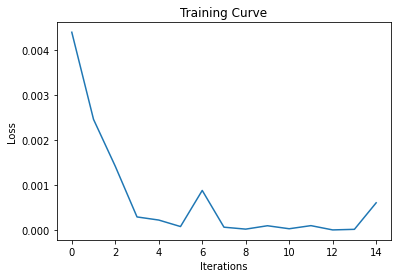

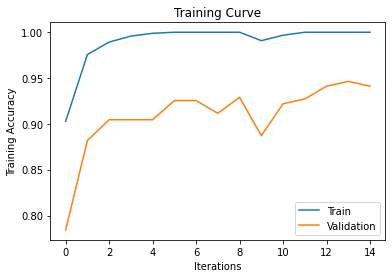

Final Training Accuracy: 0.9996181748759069
Final Validation Accuracy: 0.9408695652173913


In [ ]:
model_cnn_alexnet_toPlot = CNN_AlexNet()
train_cnn_alexnet_plot(model_cnn_alexnet_toPlot, train_dataset_cnn_alexnet, validation_dataset_cnn_alexnet, 0.001, 64, 15) 

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

**Answer**:

The accuracy here is much more higher compared to Part3(d) which shows that AlexNet is performing much better in terms of paying attention to features and it is obvious because AlexNet trained on more data and is more optimized compared to my model.

In [ ]:
use_cuda = True

def get_accuracy_for_test_alexnet(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

test_loader_alexnet = DataLoader(
    test_dataset_cnn_alexnet, batch_size=64, 
    shuffle=True
)
test_acc_alexnet = get_accuracy_for_test_alexnet(model_cnn_alexnet_toPlot, test_loader_alexnet)
print(("Test acc: {}").format(test_acc_alexnet))

Test acc: 0.8793103448275862


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset_small = datasets.ImageFolder(
    root='/content/gdrive/MyDrive/Lab3_Gestures_Summer_Small/Test',
    transform=transform
)

data_loader = DataLoader(
    test_dataset_small, batch_size=1, 
    shuffle=True, num_workers=1
)
n = 0
for imgs, labels in iter(data_loader):
  features = alexnet.features(imgs)
  features_tensor = torch.from_numpy(features.detach().numpy())
  torch.save(features_tensor.squeeze(0), '/content/gdrive/MyDrive/Lab3_Gestures_Summer_AlexNet_small/' + 'Test' + '/' + classes[labels] + '/' + str(n) + '.tensor')
  n += 1

In [ ]:
test_datasetfolder_small = datasets.DatasetFolder(
    '/content/gdrive/MyDrive/Lab3_Gestures_Summer_AlexNet_small/Test', 
    loader=torch.load, 
    extensions=('.tensor')
)

In [ ]:
data_loader = DataLoader(
    test_datasetfolder_small, batch_size=64, 
    shuffle=True, num_workers=1
)

In [ ]:
use_cuda = True

def get_accuracy_for_test_alexnet(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
test_acc_alexnet_small = get_accuracy_for_test_alexnet(model_cnn_alexnet_toPlot, data_loader)
print(("Test acc: {}").format(test_acc_alexnet_small))

Test acc: 0.8055555555555556


**Answer**:

Test accuracy now is around 81% and is almost the same as Part 4(d) which is not showing overfitting and this is because AlexNet is performing very well.